# Données et fonctions de base 

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=True)  # CF
ta = pd.read_csv("Prospectus/data/TA_2_LAGGED_notall.csv",index_col="Date", parse_dates=True)  #température
tp = pd.read_csv("Prospectus/data/TP_FR.csv",index_col="Date", parse_dates=True)  #précipitations

# Features & Target
cf_FR = cf[["FR"]]
ta_FR = ta[ta.columns[ta.columns.str.startswith("FR")]]
tp_FR = tp[tp.columns[tp.columns.str.startswith("FR")]]

data = pd.DataFrame(())

data['CF']= cf_FR
data['TP'] = tp_FR.mean(axis=1)
data['TA']=ta_FR.mean(axis=1)

In [67]:
from sklearn.metrics import r2_score, mean_squared_error
def display_result_season(y_true, y_pred):
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    seasons = y_true.index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : 
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()
def display_result(y_true, y_pred):
    """Affiche les résultats de prédiction / réels."""
    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")

    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, color="tab:blue", s=10)

    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_ylim(lb, ub)
    ax2.set_xlim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    plt.show()

# Entraînement

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Features & Target
X = pd.merge(ta_FR.rolling(window=14, min_periods=1).mean(), tp_FR.rolling(window=90, min_periods=1).sum(), left_index = True, right_index = True, suffixes = ("_TA", "_TP"))
y = data["CF"]


# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std["cos"] = np.cos(X_train_std.index.dayofyear * 2 * np.pi/365)
X_train_std["sin"] = np.sin(X_train_std.index.dayofyear * 2 * np.pi/365)

results = {"Actual": y_test}



# Ajout du lag 

In [69]:
import pandas as pd
import numpy as np

# --- 1. FEATURE ENGINEERING - FENÊTRES GLISSANTES ET LAG ---

# 1.1. Features Glissantes (Rolling Features) - VOTRE CODE INITIAL
X_roll = pd.merge(
    ta_FR.rolling(window=14, min_periods=1).mean().add_suffix("_TA_14D"), # Renommage pour clarté
    tp_FR.rolling(window=90, min_periods=1).sum().add_suffix("_TP_90D"), # Renommage pour clarté
    left_index=True, 
    right_index=True
)

# 1.2. AJOUT DES FEATURES DÉCALÉES (LAG)
lags_to_add = [1, 3] 

# Liste des DataFrames de features décalées à fusionner
lag_dfs = [X_roll] 

# Boucle pour créer et nommer les features décalées pour TA_FR et TP_FR
for lag in lags_to_add:
    # LAG sur TA_FR (Température)
    ta_lag = ta_FR.shift(lag)
    ta_lag.columns = [f'{col}_TA_lag{lag}' for col in ta_lag.columns]
    lag_dfs.append(ta_lag)
    
    # LAG sur TP_FR (Précipitations)
    tp_lag = tp_FR.shift(lag)
    tp_lag.columns = [f'{col}_TP_lag{lag}' for col in tp_lag.columns]
    lag_dfs.append(tp_lag)

# Fusion de toutes les features : roulantes + décalées
X = pd.concat(lag_dfs, axis=1)
X.dropna(inplace=True) 
y = data["CF"].loc[X.index] 


# --- 2. SUITE DU CODE : SPLIT, SCALING, ET SAISONNALITÉ ---

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=365, shuffle=False
)

# Normalisation (Scaling)
scaler = StandardScaler().set_output(transform="pandas")
X_train_std_lag = scaler.fit_transform(X_train)
X_test_std_lag = scaler.transform(X_test)

# Ajout des features saisonnières
X_train_std_lag["cos"] = np.cos(X_train_std_lag.index.dayofyear * 2 * np.pi/365)
X_train_std_lag["sin"] = np.sin(X_train_std_lag.index.dayofyear * 2 * np.pi/365)
X_test_std_lag["cos"] = np.cos(X_test_std_lag.index.dayofyear * 2 * np.pi/365)
X_test_std_lag["sin"] = np.cos(X_test_std_lag.index.dayofyear * 2 * np.pi/365)

# X_train_std contient maintenant les features roulantes, les features décalées et la saisonnalité.
# Vous pouvez maintenant entraîner votre modèle Ridge ou GBR sur X_train_std

# Application du Ridge 

R2: -0.578584
MSE: 0.017031
Bias (Intercept): 0.409070


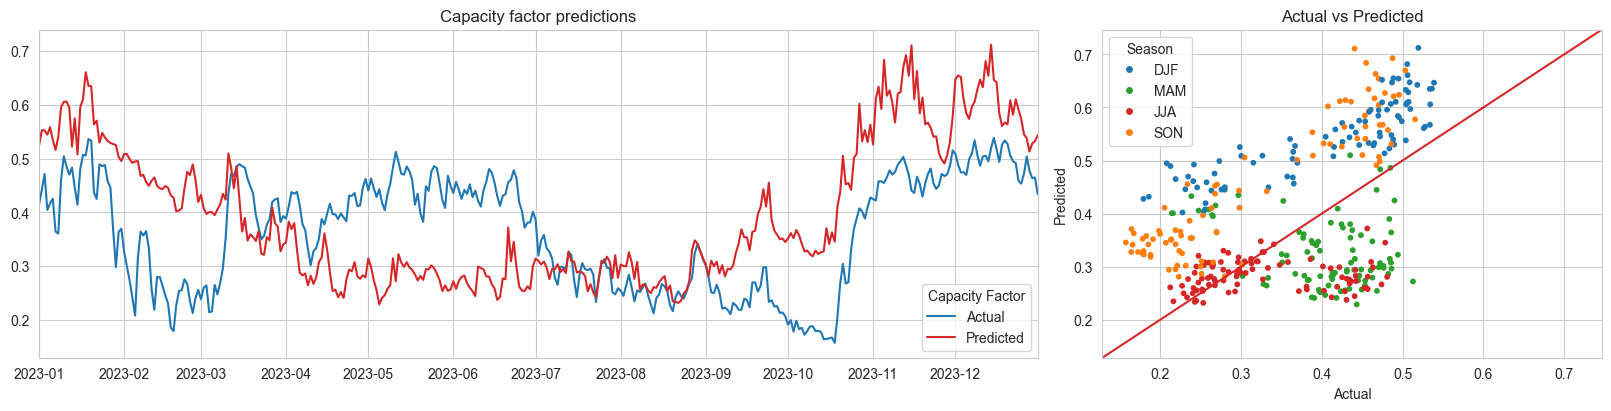

In [70]:
# votre code ici

from sklearn.linear_model import Ridge
# Normalisation
scaler = StandardScaler().set_output(transform="pandas")  # on les recentre et on les mets à la même échelle 
# scaler est une classe 


#calcul de la moy et de l'écart type sur test et sur train 
#X_train_std = scaler.fit_transform(X_train)  #fuite de données
#X_test_std = scaler.transform(X_test)   #on a utilisé que les données d'entraînement : pas de fuite de données

results = {"Actual": y_test}

ridge = Ridge()
ridge.fit(X_train_std_lag, y_train)

y_pred = ridge.predict(X_test_std_lag)
y_pred = pd.Series(y_pred, index=y_test.index)
results["RidgeStd"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

coef_df = pd.DataFrame({
    'Feature': X_train_std_lag.columns,
    'Coefficient': ridge.coef_
})

# Tri par importance absolue du coefficient pour une meilleure lisibilité
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
coef_df = coef_df.drop(columns='Abs_Coefficient')

# Affichage
print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print(f"Bias (Intercept): {ridge.intercept_:.6f}")
#print("\n--- Coefficients du Modèle Ridge ---")
#display(coef_df)
#print()

# Affichage personnalisé
display_result_season(y_test, y_pred)

# Sans lag 

In [131]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Features & Target
X = pd.merge(ta_FR.rolling(window=14, min_periods=1).mean(), tp_FR.rolling(window=90, min_periods=1).sum(), left_index = True, right_index = True, suffixes = ("_TA", "_TP"))
y = data["CF"]


# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std["cos"] = np.cos(X_train_std.index.dayofyear * 2 * np.pi/365)
X_train_std["sin"] = np.sin(X_train_std.index.dayofyear * 2 * np.pi/365)
X_test_std["cos"] = np.cos(X_test_std.index.dayofyear * 2 * np.pi/365)
X_test_std["sin"] = np.sin(X_test_std.index.dayofyear * 2 * np.pi/365)
results = {"Actual": y_test}


combined_data = pd.concat([X, y], axis=1)
combined_data.dropna(inplace=True)

# Récupérer les features et la cible ALIGNÉES
X_aligned = combined_data.drop(columns="CF")
y_aligned = combined_data["CF"]

R2: 0.587813
MSE: 0.004447
MAE: 0.055001
Bias (Intercept): 0.409032


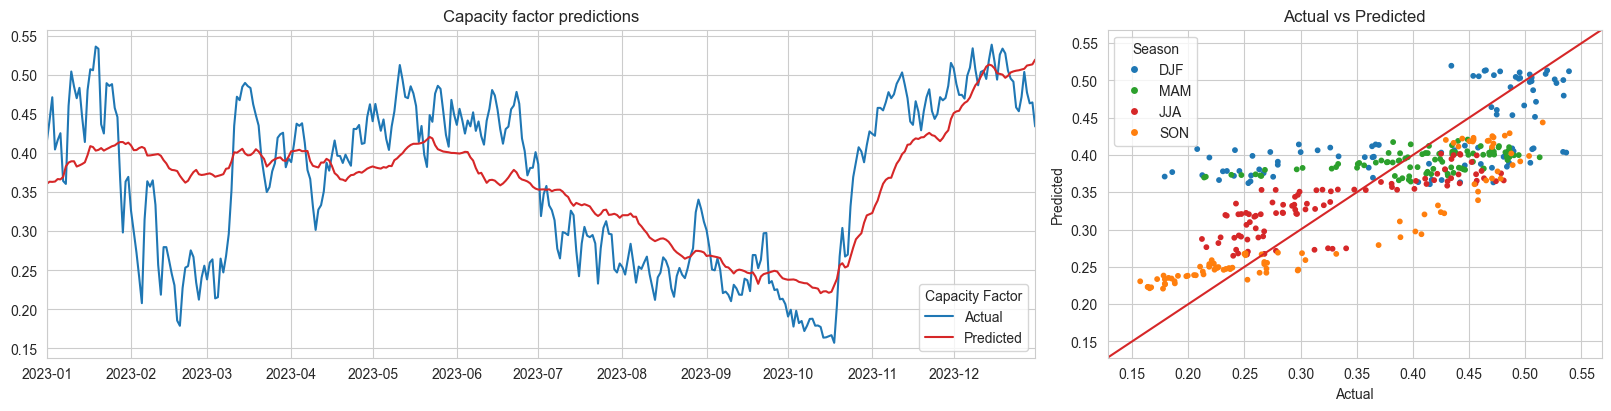

In [132]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import Ridge

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")  # on les recentre et on les mets à la même échelle 
# scaler est une classe 

results = {"Actual": y_test}

ridge = Ridge(alpha=1500)
#ridge = Ridge()

ridge.fit(X_train_std, y_train)

y_pred = ridge.predict(X_test_std)
y_pred = pd.Series(y_pred, index=y_test.index)
results["RidgeStd"] = y_pred
y_pred = y_pred - 0.05

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

coef_df = pd.DataFrame({
    'Feature': X_train_std.columns,
    'Coefficient': ridge.coef_
})

mae = mae(y_test, y_pred)

# Tri par importance absolue du coefficient pour une meilleure lisibilité
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
coef_df = coef_df.drop(columns='Abs_Coefficient')

# Affichage
print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print(f"MAE: {mae:.06f}")

print(f"Bias (Intercept): {ridge.intercept_:.6f}")
#print("\n--- Coefficients du Modèle Ridge ---")
#display(coef_df)
#print()

# Affichage personnalisé
display_result_season(y_test, y_pred)

# Search Grid sur alpha pour optimiser 

In [127]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {'alpha': np.arange(500,2000,200)}

# Utilisation de TimeSeriesSplit pour une validation croisée chronologique
tscv = TimeSeriesSplit(n_splits=5) 

# Initialisation du Grid Search
ridge_search = GridSearchCV(
    Ridge(), 
    param_grid, 
    cv=tscv, 
    scoring='r2', # Maximiser le R2
    n_jobs=-1 # Utiliser tous les cœurs
)

# Entraînement sur les données d'entraînement standardisées
ridge_search.fit(X_train_std, y_train)

best_alpha = ridge_search.best_params_['alpha']

# Utiliser le meilleur modèle pour la prédiction
y_pred = ridge_search.predict(X_test_std)
print(f"Meilleur Alpha trouvé : {best_alpha}")

Meilleur Alpha trouvé : 500
